# Matched mouse cortex data expeirment

## Step 1: Data preprocessing

In this tutorial, we will guide you through the process of preparing the required data for scCross model training. Our example will focus on utilizing the SNARE-seq dataset ([Chen, et al. 2019](https://doi.org/10.1038/s41587-019-0290-0)). This dataset contains both scRNA-seq and scATAC-seq profiles. Despite their matching nature, we will explore how to treat them as unmatched and attempt to align these two omics layers using scCross.

In [1]:
import anndata
import networkx as nx
import scanpy as sc
import sccross
import pandas as pd
import seaborn as sns
from matplotlib import rcParams


In [2]:
rcParams["figure.figsize"] = (4, 4)

### Read data

The initial step is to transform the scRNA-seq and scATAC-seq data into `AnnData` objects. In the context of `sccross`, `AnnData` serves as the standard data class. If you're not familiar with `AnnData` or need more information, you can refer to their [documentation](https://anndata.readthedocs.io/en/latest/index.html). It provides comprehensive details on constructing `AnnData` objects from scratch and importing data from various formats such as CSV, MTX, Loom, and more.

In this section, we'll simply load existing `h5ad` files, which is the native file format for `AnnData`. These `h5ad` files are used for our tutorial and can be downloaded from the following location:

* [matched_mouse_cortex_RNA.h5ad](https://drive.google.com/file/d/1cE9mdojYIqvF91cyO_funmUf5gwcdGYK/view?usp=sharing)
* [matched_mouse_cortex_ATAC.h5ad](https://drive.google.com/file/d/1dDZrJm6LL0arGdmK2JdgCNLD1zARblhL/view?usp=sharing)

In [3]:
rna = anndata.read_h5ad("matched_mouse_cortex_RNA.h5ad")
rna

AnnData object with n_obs × n_vars = 9190 × 28930
    obs: 'domain', 'cell_type'

In [4]:
atac = anndata.read_h5ad("matched_mouse_cortex_ATAC.h5ad")
atac

AnnData object with n_obs × n_vars = 9190 × 241757
    obs: 'domain', 'cell_type'

### Preprocess scRNA-seq data

Before any preprocessing, we'll create a backup of the raw UMI counts and store them in a layer named "counts." This backup will be essential for future use during the model training phase.

In [5]:
rna.layers["counts"] = rna.X.copy()

Then follow is a `scanpy` pipeline for data preprocessing ([tutorial](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html)).

Here, we use the "seurat_v3" method to select 2,000 highly variable genes.

In [6]:
sc.pp.highly_variable_genes(rna, n_top_genes=2000, flavor="seurat_v3")

In this step, we will normalize and scale the data, followed by dimension reduction using PCA. By default, we will utilize 100 principal components.

The PCA embedding obtained will serve as the initial encoder transformation in the training phase, effectively reducing the model's size.

In [7]:
sc.pp.normalize_total(rna)
sc.pp.log1p(rna)
sc.pp.scale(rna)
sc.tl.pca(rna, n_comps=100, svd_solver="auto")

We can visualize the scRNA-seq with UMAP.

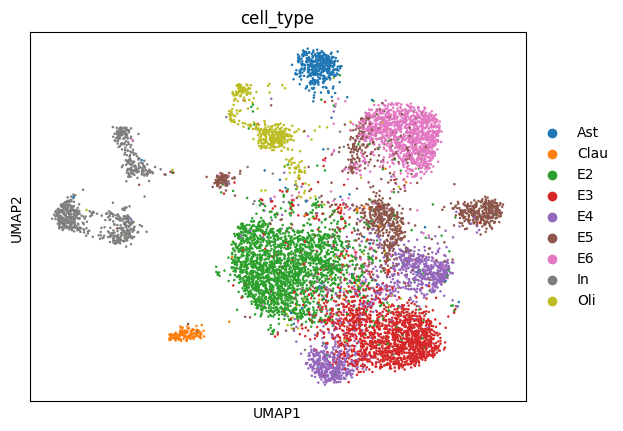

In [8]:
sc.pp.neighbors(rna, metric="cosine")
sc.tl.umap(rna)
sc.pl.umap(rna, color="cell_type")

### Preprocess scATAC-seq data

Similar to scRNA-seq, the scATAC-seq accessibility matrix is also also supposed to contain raw counts.

In [9]:
atac.X, atac.X.data

(<9190x241757 sparse matrix of type '<class 'numpy.float32'>'
 	with 22575391 stored elements in Compressed Sparse Row format>,
 array([1., 1., 1., ..., 1., 1., 1.], dtype=float32))

For the scATAC-seq data, we will perform dimension reduction using Latent Semantic Indexing (LSI) with a dimensionality set to 100. We achieve this using the [sccross.data.lsi](api/scglue.data.lsi.rst) function, which is a Python reimplementation of the LSI function in Signac. Additionally, we pass the `n_iter=15` keyword argument to [sklearn.utils.extmath.randomized_svd](https://scikit-learn.org/stable/modules/generated/sklearn.utils.extmath.randomized_svd.html). Increasing this value enhances the precision of randomized SVD.

The LSI embedding obtained here will be utilized in the training step as the initial encoder transformation, effectively reducing the model's size.

In [10]:
sccross.data.lsi(atac, n_components=100, n_iter=15)

We may also visualize the ATAC domain with UMAP.

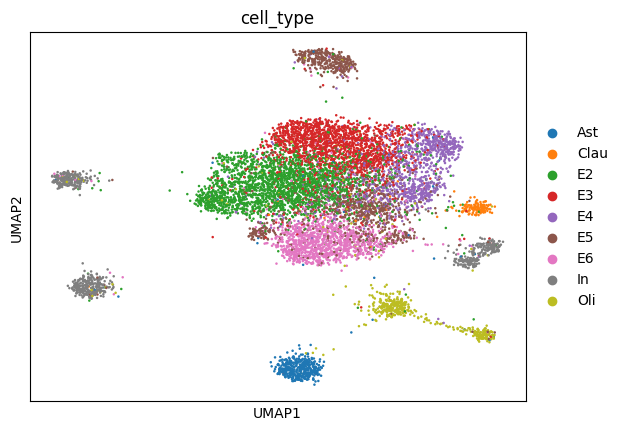

In [11]:
sc.pp.neighbors(atac, use_rep="X_lsi", metric="cosine")
sc.tl.umap(atac)
sc.pl.umap(atac, color="cell_type")

### Prepare atac data's gene activity score

To calculate the gene activity score for scATAC-seq data based on its peak features, we have re-implemented the `geneactivity` function from episcanpy in the [sccross.data.geneActivity](api/sccross.data.geneActivity.rst) function.

This process allows us to derive gene activity scores from scATAC-seq data, which can be used for downstream analysis and integration with other omics data. Please make sure the species and the location of the GTF reference file. GTF reference file can be downloaded at [GENCODE](https://www.gencodegenes.org/).

In [12]:
atac2rna = sccross.data.geneActivity(atac,gtf_file='./reference/gencode.vM30.annotation.gtf')

### Save preprocessed data files

Finally, we save the preprocessed data, for use in the training step.

In [13]:
rna.write("rna_preprocessed.h5ad", compression="gzip")
atac.write("atac_preprocessed.h5ad", compression="gzip")
atac2rna.write("atac2rna.h5ad", compression="gzip")

## Step2: Model traning

### Config dataset

Before proceeding with model training, it's essential to configure the datasets using the [sccross.models.configure_dataset](api/sccross.models.sccross.configure_dataset.rst) function. For each dataset that we aim to integrate, we specify the probabilistic generative model to be employed. In this case, we model the raw counts of both scRNA-seq and scATAC-seq data using the negative binomial distribution (`"NB"`).

Additionally, we have the option to specify whether only highly variable features should be utilized (`use_highly_variable`), which data layer to use (`use_layer`), and what preprocessing embedding (`use_rep`) should be applied as the first encoder transformation.

What's more, gene set calculation is also performed in this process. Please make sure to copy the gen_sets directory to the main path of you project.

```
project
|...
└───gene_sets
||c2.cp.v7.4.symbols.gmt
||c5.go.bp.v7.4.symbols.gmt
||Mouse_TF_targets.txt

```

- For the scRNA-seq data, we utilize the raw counts from the "counts" layer and employ the PCA embedding as the initial encoder transformation.
- For the scATAC-seq data, the raw counts are directly sourced from `atac.X`, making it unnecessary to specify a `use_layer`. Here, we apply the LSI embedding as the first encoder transformation.


In [14]:
sccross.models.configure_dataset(
    rna, "NB", use_highly_variable=True,
    use_layer = 'counts',
     use_rep="X_pca"
)

GMT file c5.go.bp.v7.4.symbols.gmt loading ... 
7481
Number of genes in c5.go.bp.v7.4.symbols.gmt 13204
GMT file c2.cp.v7.4.symbols.gmt loading ... 
2922
Number of genes in c2.cp.v7.4.symbols.gmt 10362


In [15]:
sccross.models.configure_dataset(
    atac, "NB", use_highly_variable=False,
    use_rep="X_lsi"
)

GMT file c5.go.bp.v7.4.symbols.gmt loading ... 
7481
Number of genes in c5.go.bp.v7.4.symbols.gmt 0
GMT file c2.cp.v7.4.symbols.gmt loading ... 
2922
Number of genes in c2.cp.v7.4.symbols.gmt 0


### Config MNN prior

In the [sccross.data.mnn_prior](api/sccross.data.mnn_prior.rst) function, we begin by identifying the common genes shared between the gene expression data of scRNA-seq and the gene activity score data of scATAC-seq. Using these common features, we apply the MNN (Mutual Nearest Neighbors) algorithm to establish links between cells from different omics datasets.

We leverage an implementation of the MNN correction function provided by Scanpy to reduce the distances between similar cells in different omics datasets. This process yields corrected vectors, which serve as MNN priors for each cell. These MNN priors play a crucial role in subsequent steps for data integration and alignment.

In [16]:
sccross.data.mnn_prior([rna,atac])

### Train model

In this step, we train an [sccross model](api/sccross.models.sccross.SCCROSSModel.rst) to integrate the two omics layers.

- The datasets to be integrated are defined as a dictionary, where the keys represent domain names. You have the flexibility to set domain names as you see fit, as long as they remain consistent throughout the process (see the section below for naming guidelines).

- Additionally, in the fit function, we specify a directory where model snapshots and training logs will be stored for future reference.

In [17]:
cross = sccross.models.fit_SCCROSS(
    {"rna": rna, "atac": atac},
    fit_kws={"directory": "sccross"}
)

[INFO] fit_SCCROSS: Pretraining SCCROSS model...
[INFO] autodevice: Using GPU 0 as computation device.
[INFO] SCCROSSModel: Setting `max_epochs` = 372
[INFO] SCCROSSModel: Setting `patience` = 31
[INFO] SCCROSSModel: Setting `reduce_lr_patience` = 16
"[INFO] SCCROSSTrainer: Using training directory: "0929_sccross_oldform_0.04_old_new_10_40/pretrain"\n"[INFO] SCCROSSTrainer: [Epoch 10] train={'x_rna_nll': 0.166, 'x_rna_kl': 0.011, 'x_rna_elbo': 0.177, 'x_atac_nll': 0.039, 'x_atac_kl': 0.005, 'x_atac_elbo': 0.045, 'dsc_loss': 0.0, 'vae_loss': 0.244, 'gen_loss': 0.244}, val={'x_rna_nll': 0.165, 'x_rna_kl': 0.011, 'x_rna_elbo': 0.176, 'x_atac_nll': 0.039, 'x_atac_kl': 0.005, 'x_atac_elbo': 0.045, 'dsc_loss': 0.69, 'vae_loss': 115.492, 'gen_loss': -222.669}, 3.7s elapsed
Epoch    18: reducing learning rate of group 0 to 1.0000e-04.
Epoch    18: reducing learning rate of group 0 to 1.0000e-04.
[INFO] LRScheduler: Learning rate reduction: step 1
[INFO] SCCROSSTrainer: [Epoch 20] train={'x_rna

After training, the trained model can be saved and loaded as ".dill" files. The trained model can be found in the following location:

* [matched_mouse_cortex.dill](https://drive.google.com/file/d/1_XykC1MNGy025IqbzhtIxjqxariUVhqe/view?usp=sharing)

In [18]:
cross.save("matched_mouse_cortex.dill")
#cross = sccross.models.load_model("matched_mouse_cortex.dill")

## Step3: Single cell multi-omics integration

After training the model, we can utilize the [encode_data](api/sccross.models.sccross.SCCROSSModel.encode_data.rst) method to project the single-cell omics data into integrated cell embeddings.

- The first argument of [encode_data](api/sccross.models.sccross.SCCROSSModel.encode_data.rst) specifies the domain for encoding, which should correspond to one of the previously defined domain names.
- The second argument specifies the dataset to be encoded.

As a convention, we store the resulting cell embeddings in the [obsm](https://anndata.readthedocs.io/en/latest/anndata.AnnData.obsm.html#anndata.AnnData.obsm) slot, with the name `"X_cross"`.


In [19]:
rna.obsm["X_cross"] = cross.encode_data("rna", rna)
atac.obsm["X_cross"] = cross.encode_data("atac", atac)

To jointly visualize the cell embeddings from two omics layers, we construct a combined dataset.

In [20]:
combined = anndata.concat([rna, atac])

Then we use UMAP to visualize the aligned embeddings. We can see that the two omics layers are now correctly aligned.

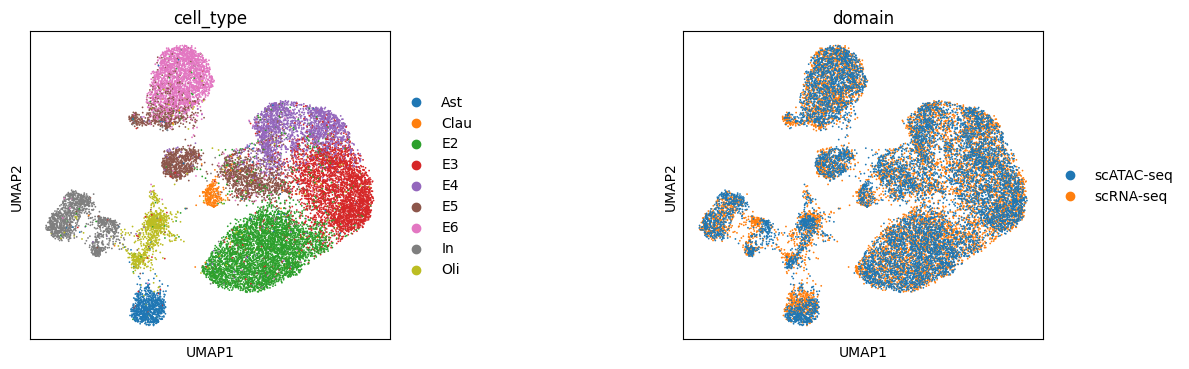

In [21]:
sc.pp.neighbors(combined, use_rep="X_cross", metric="cosine")
sc.tl.umap(combined)
sc.pl.umap(combined, color=["cell_type", "domain"], wspace=0.65)

## Step4: Single cell multi-omics cross modality generation

To achieve cross-modality data generation, we have the [generate_cross](api/sccross.models.sccross.SCCROSSModel.generate_cross.rst) function at our disposal. Using this function, we can seamlessly transfer data from one modality to another, even when the modalities are not matched.

- The key information is placed in the first position, while the data to be generated is positioned in the third position.
- The function also requires the training data of a specific modality to be provided in the remaining positions. This ensures that the generated data closely follows the scale and distribution of the real data from the training set.

By using [generate_cross](api/sccross.models.sccross.SCCROSSModel.generate_cross.rst), we can perform cross-modality data generation effectively and maintain data fidelity.

In [22]:
atacCrorna = cross.generate_cross( 'atac', 'rna', atac, rna)
atacCrorna = sc.AnnData(atacCrorna,obs=atac.obs,var= rna.var.query("highly_variable"))

Then we can process the generated data and use UMAP to visualize the cross generation result.

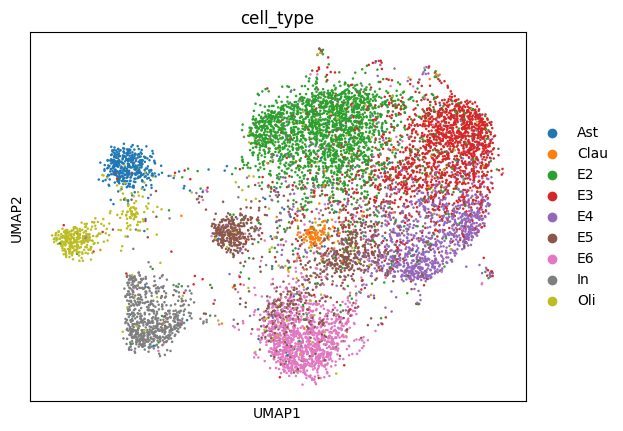

In [23]:
sc.pp.normalize_total(atacCrorna)
sc.pp.log1p(atacCrorna)
sc.pp.scale(atacCrorna)
sc.tl.pca(atacCrorna, n_comps=100, svd_solver="auto")
sc.pp.neighbors(atacCrorna,  metric="cosine")
sc.tl.umap(atacCrorna)
sc.pl.umap(atacCrorna, color=["cell_type"])

## Step5: Single cell omics data self augmentation

In our toolkit, we have the [generat_augment](api/sccross.models.sccross.SCCROSSModel.generate_augment.rst) function. It is designed to leverage the complementary information present in different omics data types. Each omics dataset can augment its performance in bio-analysis by learning from and integrating information from other omics.

In [24]:
rna.obsm['augmented'] = cross.generate_augment(  'rna', rna)

Subsequently, we can identify key differential genes within the augmented scRNA-seq data. It's important to note that if we train our model with `use_highly_variable` set to True during the data configuration, the output will exclusively contain highly variable genes. These highly variable genes are often of particular interest in bio-analysis due to their potential significance.

In [25]:
rna_augmented = sc.AnnData(rna.obsm['augmented'],obs=rna.obs,var = rna.var.query("highly_variable"))
sc.pp.normalize_total(rna_augmented)
sc.pp.log1p(rna_augmented)
sc.pp.scale(rna_augmented)
sc.tl.rank_genes_groups(rna_augmented,'cell_type')
df = pd.DataFrame(rna_augmented.uns['rank_genes_groups']['names'])
df.to_csv('rna_augmented_rankGenes_cellType.csv')

## Step6: Single cell multi-omics matched simulation

Our model offers the capability to perform single-cell multi-omics matched simulation through the [generate_multiSim](api/sccross.models.sccross.SCCROSSModel.generate_multiSim.rst) function. This function empowers us to generate matched multi-omics simulated data with flexibility in terms of the number of omics modalities, the cell states, and the number of cells.

To achieve this, we need to specify the following:

- The data sources we wish to generate simultaneously.
- The observation key associated with the simulated data.
- The cluster names to be included in the simulation.
- The desired number of cells for the simulation.

With these parameters, we can create matched multi-omics simulated data tailored to our specific requirements.

In [26]:
multi_simu = cross.generate_multiSim({'rna':rna,'atac':atac},'cell_type','Ast',len(rna[rna.obs['cell_type'].isin(['Ast'])]))
for adata in multi_simu:
    adata.obs['cell_type'] = 'Ast_s'

We can concate the simulated data with the original data.

In [27]:
rna_temp = rna.copy()
rna_temp.X = rna_temp.layers['counts']
rna_temp = rna_temp[:,rna_temp.var.query("highly_variable").index]
rna_temp = sc.concat([rna_temp,multi_simu[0]])

In [28]:
atac_temp = atac.copy()
atac_temp = atac_temp[:,atac_temp.var.query("highly_variable").index]
atac_temp = sc.concat([atac_temp,multi_simu[1]])

Then we can process and draw UMAP for the simulated data.

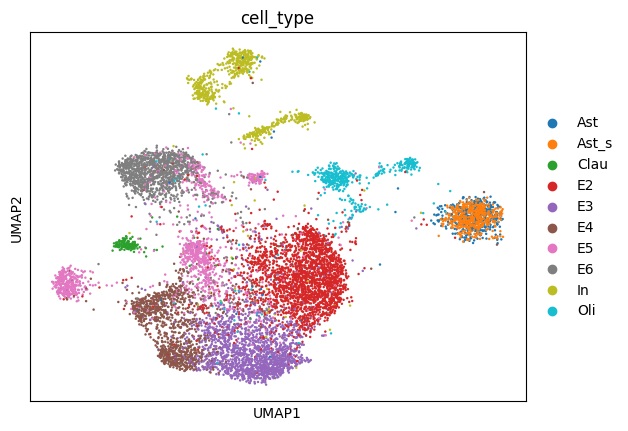

In [29]:
sc.pp.normalize_total(rna_temp)
sc.pp.log1p(rna_temp)
sc.pp.scale(rna_temp)
sc.tl.pca(rna_temp, n_comps=100, svd_solver="auto")
sc.pp.neighbors(rna_temp,  metric="cosine")
sc.tl.umap(rna_temp)
sc.pl.umap(rna_temp, color=["cell_type"])

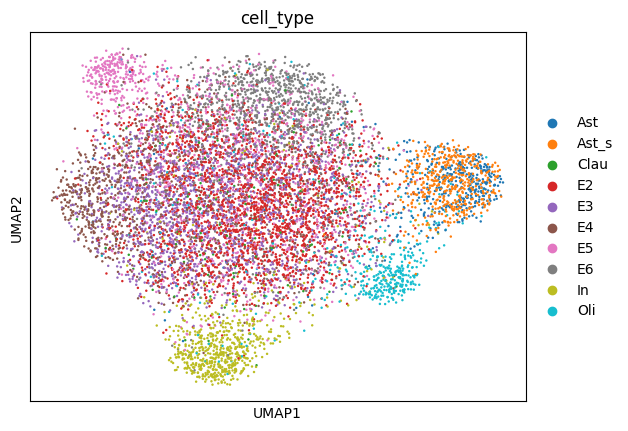

In [30]:
sccross.data.lsi(atac_temp, n_components=100, n_iter=15)
sc.pp.neighbors(atac_temp, use_rep = 'X_lsi',  metric="cosine")
sc.tl.umap(atac_temp)
sc.pl.umap(atac_temp, color=["cell_type"])

## Step7: Single cell multi-omics in-silico perturbation

### Identify genes' differential expression between cell clusters with in-silico perturbation

For the purpose of identifying differential gene expression between cell clusters, we have developed the [perturbation_difGenes](api/sccross.models.sccross.SCCROSSModel.perturbation_difGenes.rst) function. This function serves as a valuable tool for assessing the importance of genes by measuring the movement of latent expression between cell clusters during in-silico perturbations of the input data.

In order to utilize this function effectively, you need to specify the following:

- The modality's key that corresponds to the target data.
- The actual modality's data.
- The observation key associated with the perturbation cell clusters.
- The reference cell cluster for comparison.
- The genes you intend to perturb within the analysis.

With these parameters, you can gain insights into the differential gene expression patterns between cell clusters and assess the impact of gene perturbations on the latent expression profiles.

In [31]:
import random
rna.X = rna.layers['counts']
genes = random.sample(rna.var.query("highly_variable").index.to_numpy().tolist(),100) 
difGenes = cross.perturbation_difGenes('rna',rna,'cell_type','Clau','Ast',genes)
difGenes.to_csv('difGens.csv')

The bigger the number in the table means more close to the reference after the up or down perturbated.

In [32]:
difGenes

,up,down
0,Cux1,Cux1
1,Lingo2,Ccdc3
2,Xpa,Rhod
3,Qk,Mal
4,Foxp2,Cntnap5b
...,...,...
95,Hdc,Ppp1r1a
96,Fhod1,Rbms3
97,Mcur1,Egr4
98,Fjx1,Fhod1


### Maintain in-silico perturbation while cross generation

A noteworthy capability of our model is its ability to preserve in-silico perturbations made within one modality while transitioning them to another through cross-modality generation. This means that perturbations initiated in one modality can be seamlessly transferred and observed in another, enabling a cohesive exploration of perturbation effects and responses across different modalities. Here, for fair, we randomly select 100 genes in high variable genes to perform the experiment as an example.

In [33]:
rna[rna.obs['cell_type'].isin(['Clau']),difGenes['up'][:100]].X += 0.5*rna[rna.obs['cell_type'].isin(['Clau']),difGenes['up'][:100]].X
rnaCroatac = cross.generate_cross( 'rna', 'atac', rna, atac)
rnaCroatac = sc.AnnData(rnaCroatac,obs=rna.obs,var= atac.var.query("highly_variable"))
rnaCroatac

AnnData object with n_obs × n_vars = 9190 × 241757
    obs: 'domain', 'cell_type'